In [3]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [4]:
# Load the diabetes dataset

from sklearn.datasets import load_diabetes

diabetes_dataset=load_diabetes()
print(diabetes_dataset["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [5]:
# Save the input and target variables

# print(diabetes_dataset.keys())

data=diabetes_dataset["data"]
targets=diabetes_dataset["target"]


In [6]:
# Normalise the target data (this will make clearer training curves)

targets=(targets-targets.mean(axis=0))/targets.std()


In [7]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data,test_data, train_targets,test_targets=train_test_split(data,targets,test_size=0.1)

print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [8]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model= Sequential([
        Dense(128,activation='relu',input_shape=(train_data.shape[1],)),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(1)
    ])
    return model

model=get_model()

In [20]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1408      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 1

In [21]:
# Compile the model

model.compile(optimizer='adam',loss='mse',metrics=['mae'])

In [22]:
# Train the model, with some of the data reserved for validation

history=model.fit(train_data,train_targets,epochs=100,
                 validation_split=0.15,batch_size=64,verbose=False)

In [23]:
# Evaluate the model on the test set

model.evaluate(test_data,test_targets,verbose=2)

45/1 - 0s - loss: 0.7380 - mae: 0.7053


[0.789426408873664, 0.7052976]

#### Plot the learning curves

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

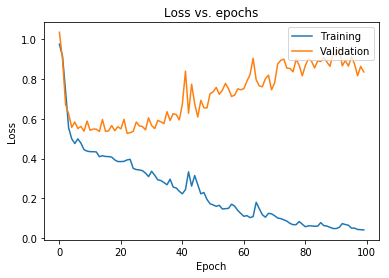

In [25]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [15]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [16]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [28]:
# Re-build the model with weight decay and dropout layers

model=get_regularised_model(1e-5,0.3)


In [29]:
# Compile the model

model.compile(optimizer='adam',
             loss='mse',
             metrics=['mae'])

In [30]:
# Train the model, with some of the data reserved for validation

history=model.fit(train_data,train_targets,epochs=100,
                 validation_split=0.15,batch_size=64,verbose=False)

In [31]:
# Evaluate the model on the test set

model.evaluate(test_data,test_targets,verbose=2)

45/1 - 0s - loss: 0.5170 - mae: 0.6731


[0.6800059119860331, 0.6730833]

#### Plot the learning curves

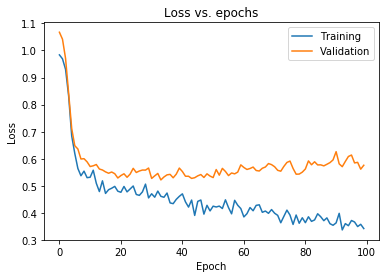

In [32]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [44]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    
    def on_train_begin(self,logs=None):
        print("Starting training....")
        
    def on_epoch_begin(self,epoch,logs=None):
        print(f"Starting epoch{epoch}")
        
    def on_train_batch_begin(self,batch,logs=None):
        print(f"Training: Starting batch {batch}")
        
    def on_train_batch_end(self,batch,log=None):
        print(f"Training: Finished batch {batch}")
        
    def on_epoch_end(self,epoch,logs=None):
        print(f"Finished epoch {epoch}")
        
    def on_train_end(self,logs=None):
        print("Finished training")

In [49]:
class TestCallback(Callback):
    
    def on_test_begin(self,logs=None):
        print("Starting test....")

    def on_test_batch_begin(self,batch,logs=None):
        print(f"test: Starting batch {batch}")
        
    def on_test_batch_end(self,batch,log=None):
        print(f"test: Finished batch {batch}")
        
    def on_test_end(self,logs=None):
        print("Finished test")

In [55]:
class PredictCallback(Callback):
    
    def on_predict_begin(self,logs=None):
        print("Starting predict....")

    def on_predict_batch_begin(self,batch,logs=None):
        print(f"predict: Starting batch {batch}")
        
    def on_predict_batch_end(self,batch,log=None):
        print(f"predict: Finished batch {batch}")
        
    def on_predict_end(self,logs=None):
        print("Finished predict")

In [45]:
# Re-build the model

model=get_regularised_model(1e-5,0.3)

In [46]:
# Compile the model

model.compile(optimizer='adam',
             loss='mse')

#### Train the model with the callback

In [47]:
# Train the model, with some of the data reserved for validation

history=model.fit(train_data,train_targets,epochs=3,
                 batch_size=128,verbose=False,callbacks=[TrainingCallback()])

Starting training....
Starting epoch0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 0
Starting epoch1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 1
Starting epoch2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 2
Finished training


In [56]:
# Evaluate the model

model.evaluate(test_data,test_targets,verbose=False,callbacks=[TestCallback()])

Starting test....
test: Starting batch 0
test: Finished batch 0
test: Starting batch 1
test: Finished batch 1
Finished test


1.0537930832968818

In [61]:
# Make predictions with the model

model.predict(test_data,verbose=False,callbacks=[PredictCallback()])

Starting predict....
predict: Starting batch 0
predict: Finished batch 0
predict: Starting batch 1
predict: Finished batch 1
Finished predict


array([[ 0.01418039],
       [-0.05069291],
       [ 0.0007322 ],
       [ 0.00794649],
       [ 0.03018367],
       [ 0.02263624],
       [-0.03318577],
       [-0.02466579],
       [-0.00245919],
       [ 0.02297171],
       [ 0.0181956 ],
       [-0.01035328],
       [-0.01887478],
       [-0.04745386],
       [ 0.01648358],
       [ 0.01141299],
       [-0.01188576],
       [ 0.02799352],
       [ 0.00721101],
       [-0.03407196],
       [-0.03511329],
       [ 0.00198771],
       [ 0.00723356],
       [-0.04807093],
       [ 0.01410876],
       [-0.02879177],
       [-0.00124882],
       [ 0.01244908],
       [-0.01221911],
       [ 0.00482765],
       [-0.00091914],
       [-0.0391991 ],
       [ 0.01661753],
       [ 0.00892076],
       [-0.01463985],
       [ 0.02601073],
       [ 0.00591375],
       [-0.02263823],
       [ 0.02342699],
       [ 0.02559462],
       [ 0.02195133],
       [ 0.00304829],
       [-0.02686865],
       [-0.01701908],
       [-0.00371819]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [22]:
# Re-train the unregularised model

unregularised_model=get_model()
unregularised_model.compile(optimizer='adam',loss='mse')
unreg_history=unregularised_model.fit(train_data,train_targets,epochs=100,
                                     validation_split=0.15,batch_size=64, verbose=False,
                                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

In [23]:
# Evaluate the model on the test set

unregularised_model.evaluate(test_data,test_targets,verbose=2)

45/1 - 0s - loss: 0.4865


0.606902845038308

In [27]:
# Re-train the regularised model

regularised_model=get_regularised_model(1e-8,0.2)
regularised_model.compile(optimizer='adam',loss='mse')
reg_history=regularised_model.fit(train_data,train_targets,epochs=100,
                                     validation_split=0.15,batch_size=64, verbose=False,
                                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

In [28]:
# Evaluate the model on the test set

regularised_model.evaluate(test_data,test_targets,verbose=2)

45/1 - 0s - loss: 0.3903


0.5026052395502726

#### Plot the learning curves

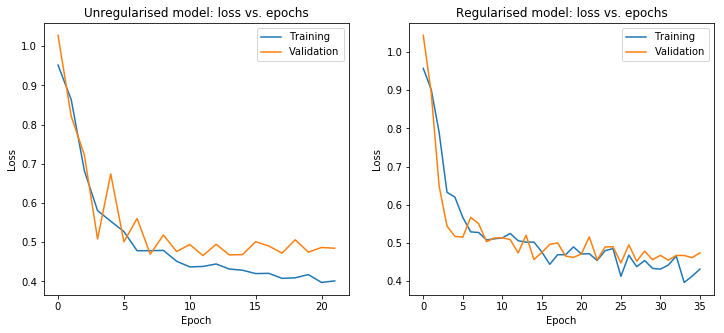

In [29]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()